## Setup: Load Example Data and Compute Metrics

In [1]:
from huggingface_hub import snapshot_download
from pathlib import Path
from dosemetrics import Dose
from dosemetrics.io import load_structure_set
from dosemetrics.metrics import dvh, statistics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Download dataset
data_path = Path(snapshot_download(
    repo_id="contouraid/dosemetrics-data",
    repo_type="dataset"
))

# Load test subject
subject_path = data_path / "longitudinal" / "time_point_1"
dose = Dose.from_nifti(subject_path / "Dose.nii.gz", name="Clinical")
structures = load_structure_set(subject_path)

# Create output directory
output_dir = Path("dosemetrics_output")
output_dir.mkdir(exist_ok=True)

print(f"✓ Data loaded")
print(f"✓ Output directory: {output_dir}")

/Users/amithkamath/Repositories/ContourAId/dosemetrics/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 165 files: 100%|██████████| 165/165 [00:00<00:00, 544929.26it/s]


✓ Data loaded
✓ Output directory: dosemetrics_output


## 1. Exporting DVH Data to CSV

Export raw DVH data for further analysis in spreadsheet software.

In [2]:
# Use the create_dvh_table function to compute all DVHs at once
dvh_df = dvh.create_dvh_table(dose, structures, step_size=0.1)

# Export to CSV
csv_file = output_dir / "dvh_curves.csv"
dvh_df.to_csv(csv_file, index=False, float_format='%.3f')
print(f"✓ DVH curves exported to: {csv_file}")
print(f"  Shape: {dvh_df.shape}")
print(f"\nFirst few rows:")
print(dvh_df.head())

✓ DVH curves exported to: dosemetrics_output/dvh_curves.csv
  Shape: (6654, 3)

First few rows:
   Dose  Structure  Volume
0   0.0  Pituitary   100.0
1   0.1  Pituitary   100.0
2   0.2  Pituitary   100.0
3   0.3  Pituitary   100.0
4   0.4  Pituitary   100.0


## 2. Exporting Summary Statistics

Create a summary table with key dosimetric parameters.

In [3]:
# Compute summary statistics for all structures
summary_data = []
for structure_name in structures.structure_names:
    structure = structures.get_structure(structure_name)
    stats = statistics.compute_dose_statistics(dose, structure)
    
    summary_data.append({
        'Structure': structure_name,
        'Mean_Dose_Gy': stats['mean_dose'],
        'Max_Dose_Gy': stats['max_dose'],
        'Min_Dose_Gy': stats['min_dose'],
        'D98_Gy': stats['D98'],
        'D95_Gy': stats['D95'],
        'D50_Gy': stats['D50'],
        'D02_Gy': stats['D02'],
    })

summary_df = pd.DataFrame(summary_data)

# Export to CSV
summary_csv = output_dir / "dose_statistics.csv"
summary_df.to_csv(summary_csv, index=False, float_format='%.2f')
print(f"✓ Dose statistics exported to: {summary_csv}")
print(f"\nSummary statistics:")
print(summary_df.to_string(index=False))

✓ Dose statistics exported to: dosemetrics_output/dose_statistics.csv

Summary statistics:
      Structure  Mean_Dose_Gy  Max_Dose_Gy  Min_Dose_Gy    D98_Gy    D95_Gy    D50_Gy    D02_Gy
      Pituitary     33.124737    49.973858    27.258350 27.363830 27.787194 32.107286 43.285683
   OpticNerve_L     40.706139    58.409367    22.025936 23.030230 25.094957 39.554611 58.292413
      Cochlea_R      2.723948     3.240509     2.224194  2.233351  2.247086  2.733153  3.206919
            CTV     60.477562    65.710373    50.679634 57.885999 58.470163 60.496662 62.887984
   OpticNerve_R     16.820459    36.039921    10.634932 11.238183 11.359985 14.608663 33.987897
      Cochlea_L      5.975782     7.400981     4.387792  4.410209  4.443833  6.951258  7.353055
            PTV     60.149307    65.710373    48.602383 56.572667 57.661037 60.253080 62.806777
LacrimalGland_L     22.810709    41.746353     9.209210  9.893125 12.393974 22.562616 38.566914
          Eye_R      9.883802    26.933418   

## 3. Exporting to Excel with Multiple Sheets

Combine multiple tables into a single Excel file.

In [4]:
# Create Excel file with multiple sheets
# Note: This requires openpyxl package
try:
    excel_file = output_dir / "dosimetric_analysis.xlsx"

    with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
        # Sheet 1: Summary statistics
        summary_df.to_excel(writer, sheet_name='Summary', index=False)
        
        # Sheet 2: DVH curves
        dvh_df.to_excel(writer, sheet_name='DVH_Curves', index=False)
        
        # Sheet 3: Constraint compliance
        constraints_data = []
        constraint_limits = {
            'PTV': [('D95', 95, '>=', 50.0)],
            'BrainStem': [('Max', 100, '<=', 54.0)],
            'Chiasm': [('Max', 100, '<=', 54.0)],
            'Eye_L': [('Max', 100, '<=', 45.0)],
            'Eye_R': [('Max', 100, '<=', 45.0)],
        }
        
        for structure_name, constraints in constraint_limits.items():
            if structure_name in structures:
                structure = structures.get_structure(structure_name)
                stats_struct = statistics.compute_dose_statistics(dose, structure)
                
                for metric_name, volume_pct, operator, limit in constraints:
                    if metric_name == 'Max':
                        value = stats_struct['max_dose']
                    else:
                        # Use D95 as the metric
                        value = stats_struct[f'D{volume_pct:02d}'] if f'D{volume_pct:02d}' in stats_struct else stats_struct['D95']
                    
                    if operator == '>=':
                        passed = value >= limit
                    else:  # '<='
                        passed = value <= limit
                    
                    constraints_data.append({
                        'Structure': structure_name,
                        'Constraint': f"{metric_name} {operator} {limit} Gy",
                        'Value_Gy': value,
                        'Limit_Gy': limit,
                        'Pass': 'Yes' if passed else 'No'
                    })
        
        constraints_df = pd.DataFrame(constraints_data)
        constraints_df.to_excel(writer, sheet_name='Constraints', index=False)

    print(f"✓ Excel file exported to: {excel_file}")
    print(f"  Contains 3 sheets: Summary, DVH_Curves, Constraints")
    
except ImportError:
    print("⚠ openpyxl package not available. Skipping Excel export.")
    print("  Install with: pip install openpyxl")
    print("  CSV files are still available for data export.")

⚠ openpyxl package not available. Skipping Excel export.
  Install with: pip install openpyxl
  CSV files are still available for data export.


## 4. Creating Publication-Quality DVH Plots

Generate high-resolution plots suitable for publications.

✓ Plot saved: dosemetrics_output/dvh_plot.png
✓ Plot saved: dosemetrics_output/dvh_plot.pdf
✓ Plot saved: dosemetrics_output/dvh_plot.svg


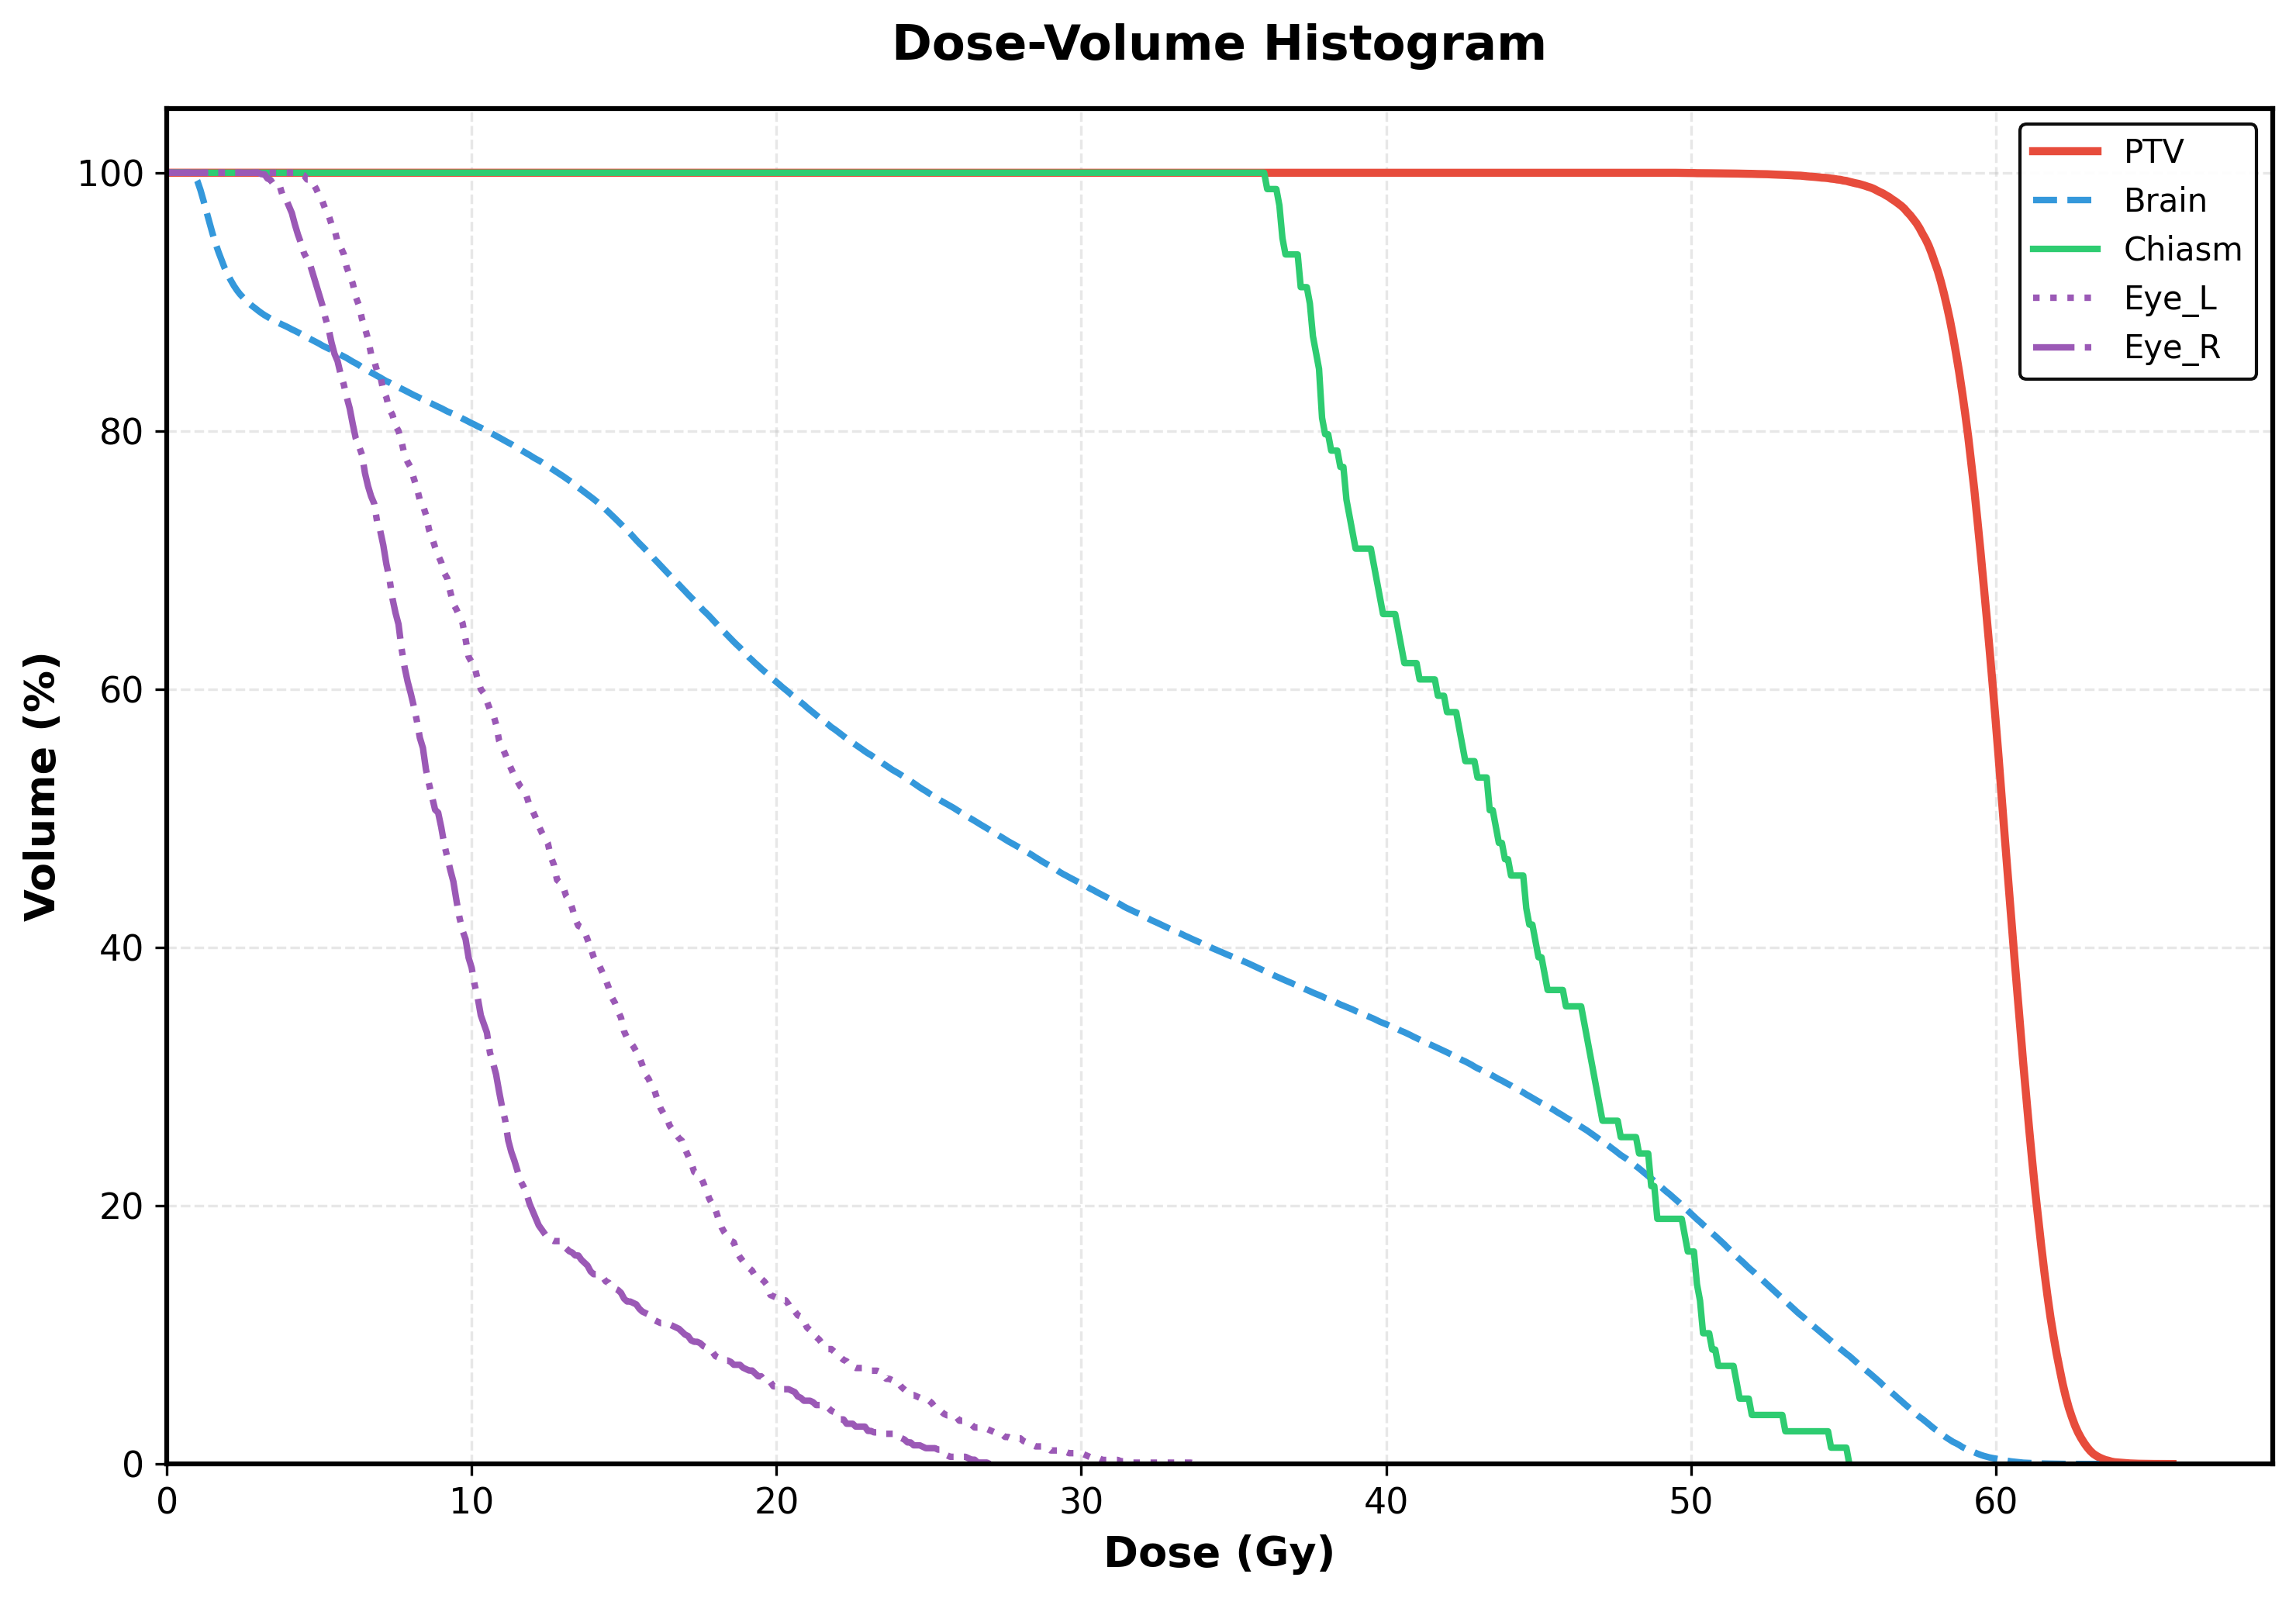

In [5]:
# Configure matplotlib for publication quality
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 2

# Create figure
fig, ax = plt.subplots(figsize=(10, 7), dpi=300)

# Define colors and line styles
structure_styles = {
    'PTV': {'color': '#E74C3C', 'linestyle': '-', 'linewidth': 2.5},
    'Brain': {'color': '#3498DB', 'linestyle': '--', 'linewidth': 2},
    'BrainStem': {'color': '#E67E22', 'linestyle': '-', 'linewidth': 2},
    'Chiasm': {'color': '#2ECC71', 'linestyle': '-', 'linewidth': 2},
    'Eye_L': {'color': '#9B59B6', 'linestyle': ':', 'linewidth': 2},
    'Eye_R': {'color': '#9B59B6', 'linestyle': '-.', 'linewidth': 2},
}

# Plot DVHs
for structure_name, style in structure_styles.items():
    if structure_name in structures:
        structure = structures.get_structure(structure_name)
        dose_bins, volume_pcts = dvh.compute_dvh(dose, structure)
        ax.plot(dose_bins, volume_pcts, label=structure_name, **style)

# Formatting
ax.set_xlabel('Dose (Gy)', fontsize=13, fontweight='bold')
ax.set_ylabel('Volume (%)', fontsize=13, fontweight='bold')
ax.set_title('Dose-Volume Histogram', fontsize=15, fontweight='bold', pad=15)
ax.legend(loc='best', framealpha=0.95, fontsize=10, edgecolor='black')
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim(0, None)
ax.set_ylim(0, 105)

# Add margin
plt.tight_layout()

# Save in multiple formats
for fmt in ['png', 'pdf', 'svg']:
    output_file = output_dir / f"dvh_plot.{fmt}"
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✓ Plot saved: {output_file}")

plt.show()

## 5. Creating Comparison Plots

Compare two treatment plans side by side.

✓ Comparison plot saved: dosemetrics_output/dvh_comparison.png


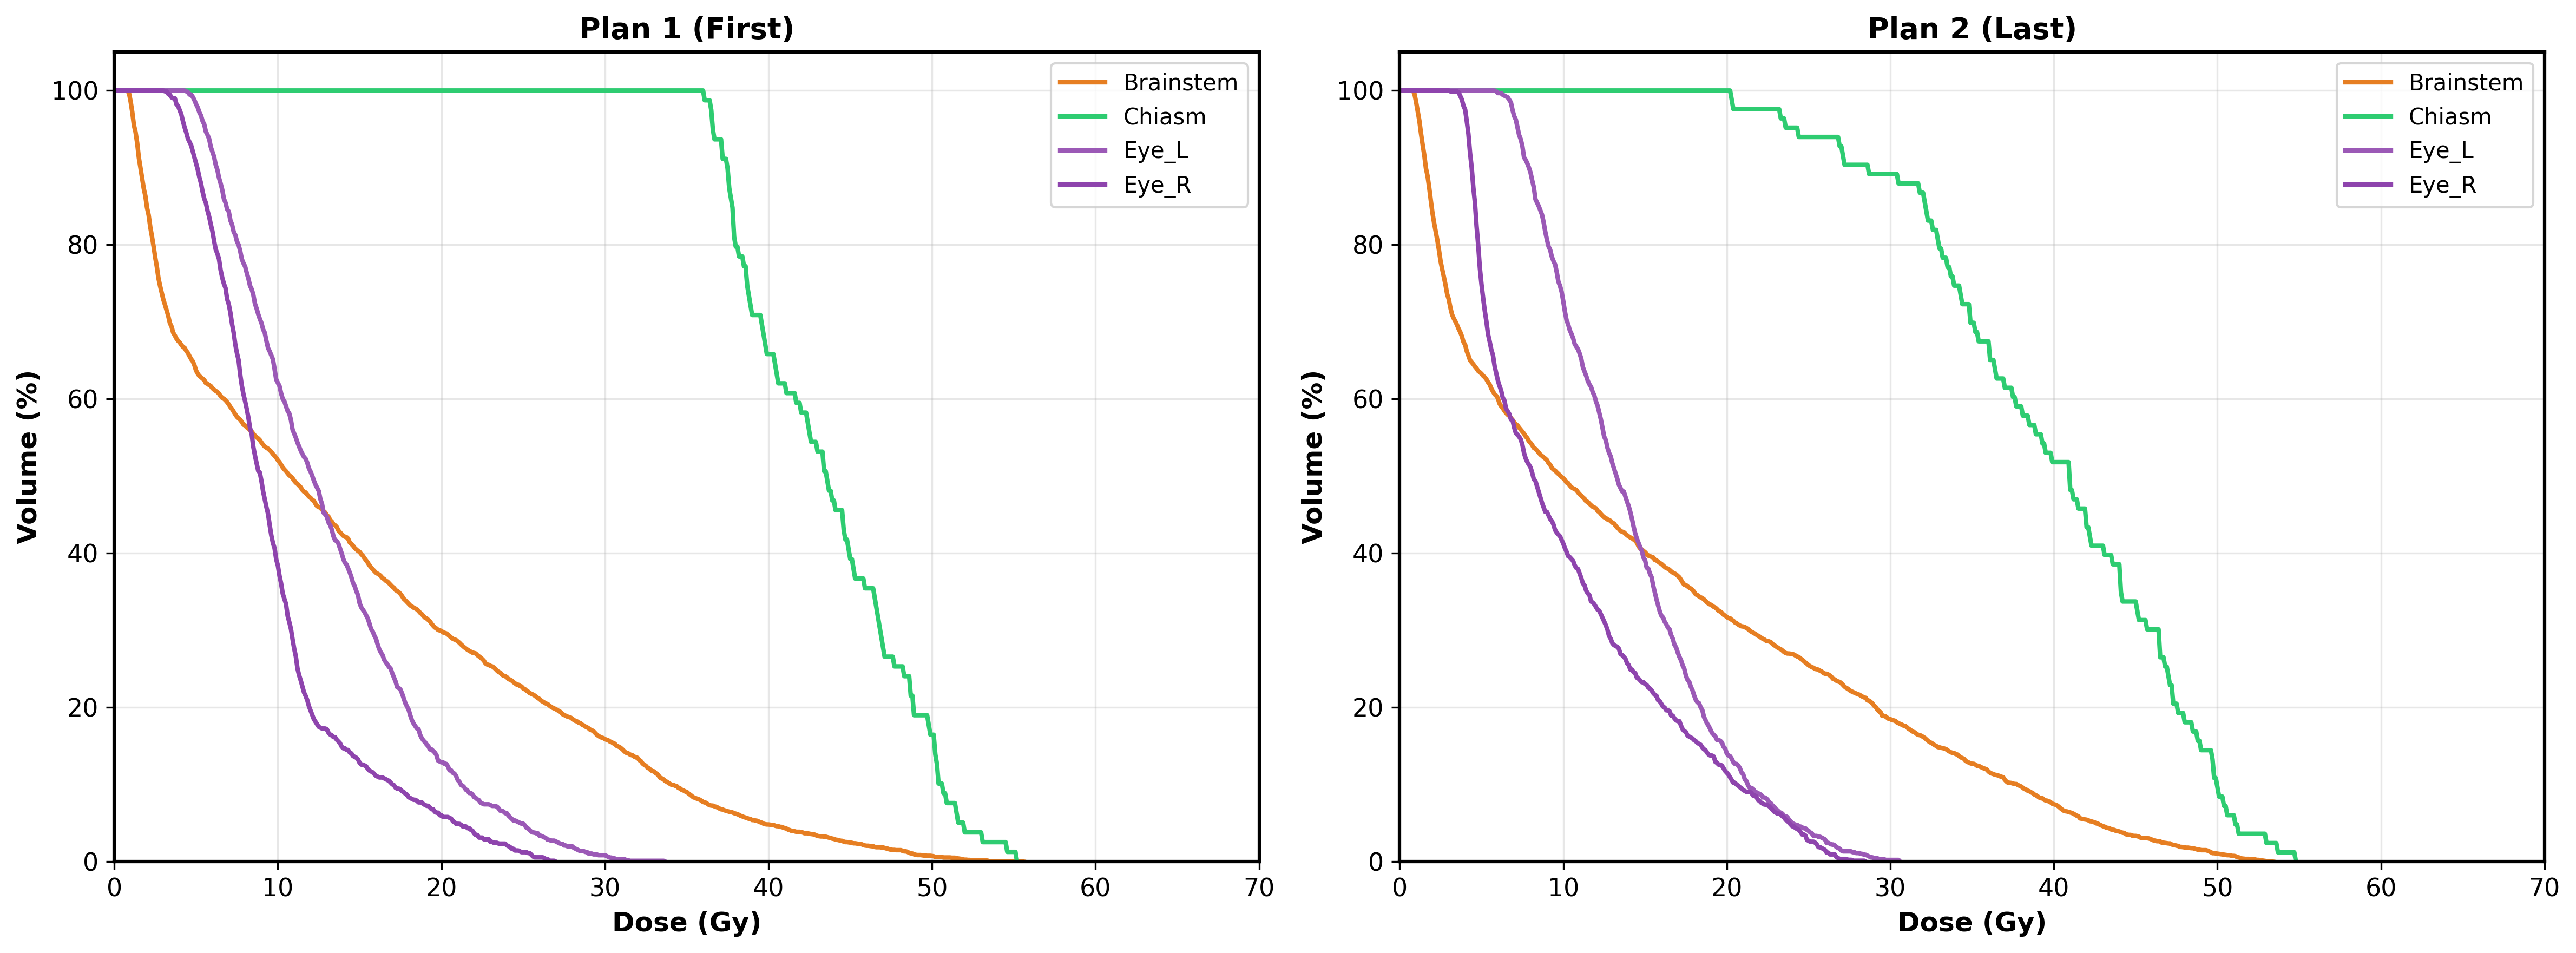

In [6]:
# Load comparison plans
plan1_path = data_path / "longitudinal" / "time_point_1"
plan2_path = data_path / "longitudinal" / "time_point_2"

dose1 = Dose.from_nifti(plan1_path / "Dose.nii.gz", name="Plan1")
structures1 = load_structure_set(plan1_path)
dose2 = Dose.from_nifti(plan2_path / "Dose.nii.gz", name="Plan2")
structures2 = load_structure_set(plan2_path)

# Create side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=300)

compare_structures = ['Brainstem', 'Chiasm', 'Eye_L', 'Eye_R']
colors = ['#E67E22', '#2ECC71', '#9B59B6', '#8E44AD']

# Plot Plan 1
for i, struct_name in enumerate(compare_structures):
    if struct_name in structures1:
        structure = structures1.get_structure(struct_name)
        dose_bins, volume_pcts = dvh.compute_dvh(dose1, structure)
        ax1.plot(dose_bins, volume_pcts, 
                label=struct_name, color=colors[i], linewidth=2)

ax1.set_xlabel('Dose (Gy)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Volume (%)', fontsize=12, fontweight='bold')
ax1.set_title('Plan 1 (First)', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 70)
ax1.set_ylim(0, 105)

# Plot Plan 2
for i, struct_name in enumerate(compare_structures):
    if struct_name in structures2:
        structure = structures2.get_structure(struct_name)
        dose_bins, volume_pcts = dvh.compute_dvh(dose2, structure)
        ax2.plot(dose_bins, volume_pcts, 
                label=struct_name, color=colors[i], linewidth=2)

ax2.set_xlabel('Dose (Gy)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Volume (%)', fontsize=12, fontweight='bold')
ax2.set_title('Plan 2 (Last)', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 70)
ax2.set_ylim(0, 105)

plt.tight_layout()

# Save
comparison_file = output_dir / "dvh_comparison.png"
plt.savefig(comparison_file, dpi=300, bbox_inches='tight')
print(f"✓ Comparison plot saved: {comparison_file}")
plt.show()

## 6. Batch Export for Multiple Subjects

Process and export results for multiple subjects at once.

In [7]:
# Find all subject folders
subject_folders = [d for d in data_path.iterdir() 
                  if d.is_dir() and not d.name.startswith('.')]

print(f"Found {len(subject_folders)} subjects to process")

# Process each subject
batch_results = []

for subject_folder in subject_folders:
    print(f"\nProcessing: {subject_folder.name}")
    
    try:
        # Load data
        dose_file = subject_folder / "Dose.nii.gz"
        if not dose_file.exists():
            print(f"  ⚠ No dose file found, skipping...")
            continue
            
        dose_subj = Dose.from_nifti(dose_file, name=subject_folder.name)
        structures_subj = load_structure_set(subject_folder)
        
        # Compute metrics for key structures
        for structure_name in ['PTV', 'Brain', 'BrainStem', 'Brainstem']:
            if structure_name in structures_subj:
                structure = structures_subj.get_structure(structure_name)
                stats_subj = statistics.compute_dose_statistics(dose_subj, structure)
                
                batch_results.append({
                    'Subject': subject_folder.name,
                    'Structure': structure_name,
                    'Mean_Dose_Gy': stats_subj['mean_dose'],
                    'Max_Dose_Gy': stats_subj['max_dose'],
                    'D95_Gy': stats_subj['D95'],
                    'D50_Gy': stats_subj['D50'],
                })
        
        print(f"  ✓ Completed")
        
    except Exception as e:
        print(f"  ✗ Error: {e}")

# Create DataFrame and export
batch_df = pd.DataFrame(batch_results)
batch_file = output_dir / "batch_analysis.csv"
batch_df.to_csv(batch_file, index=False, float_format='%.2f')

print(f"\n✓ Batch analysis complete!")
print(f"  Processed {len(set(batch_df['Subject']))} subjects")
print(f"  Results saved to: {batch_file}")
print(f"\nSample results:")
print(batch_df.head(10).to_string(index=False))

Found 3 subjects to process

Processing: test_subject
  ✓ Completed

Processing: longitudinal
  ⚠ No dose file found, skipping...

Processing: dicom
  ⚠ No dose file found, skipping...

✓ Batch analysis complete!
  Processed 1 subjects
  Results saved to: dosemetrics_output/batch_analysis.csv

Sample results:
     Subject Structure  Mean_Dose_Gy  Max_Dose_Gy    D95_Gy    D50_Gy
test_subject       PTV     58.128494    63.897976 48.174910 59.812725
test_subject     Brain     34.136818    62.404442 21.405126 31.022207
test_subject Brainstem     58.420036    61.649776 50.661014 59.999817


## 7. Summary of Exported Files

Review all files created during this analysis.

In [8]:
import os

print("Exported Files Summary:")
print("=" * 70)

for file in sorted(output_dir.iterdir()):
    if file.is_file():
        size_kb = file.stat().st_size / 1024
        print(f"{file.name:40s} {size_kb:8.1f} KB")

print("=" * 70)
total_size = sum(f.stat().st_size for f in output_dir.iterdir() if f.is_file()) / 1024
print(f"{'Total':40s} {total_size:8.1f} KB")

print(f"\n✓ All exports complete!")
print(f"\nOutput directory: {output_dir.absolute()}")

Exported Files Summary:
batch_analysis.csv                            0.2 KB
dose_statistics.csv                           0.8 KB
dvh_comparison.png                          337.7 KB
dvh_curves.csv                              145.7 KB
dvh_plot.pdf                                 25.9 KB
dvh_plot.png                                266.5 KB
dvh_plot.svg                                 53.0 KB
Total                                       829.8 KB

✓ All exports complete!

Output directory: /Users/amithkamath/Repositories/ContourAId/dosemetrics/docs/notebooks/dosemetrics_output


## Summary

In this notebook, you learned how to:

1. ✓ Export DVH data to CSV
2. ✓ Create summary statistics tables
3. ✓ Export to Excel with multiple sheets
4. ✓ Create publication-quality plots (PNG, PDF, SVG)
5. ✓ Generate comparison plots
6. ✓ Perform batch processing and export
7. ✓ Manage output files

## Export Formats Summary

| Format | Use Case | Files |
|--------|----------|-------|
| **CSV** | Spreadsheet analysis, data sharing | `dvh_curves.csv`, `dose_statistics.csv` |
| **Excel** | Comprehensive analysis in one file | `dosimetric_analysis.xlsx` |
| **PNG** | Presentations, web display | `dvh_plot.png` |
| **PDF** | Publications, reports | `dvh_plot.pdf` |
| **SVG** | Scalable graphics, editing | `dvh_plot.svg` |

## Next Steps

- **Automation**: Create scripts to run batch analysis automatically
- **Integration**: Incorporate exports into clinical workflows
- **Custom Reports**: Modify HTML templates for specific needs

## References

- [DoseMetrics Documentation](https://contouraid.github.io/dosemetrics/)
- [Batch Processing Guide](https://contouraid.github.io/dosemetrics/user-guide/batch-processing/)
- [GitHub Repository](https://github.com/contouraid/dosemetrics)